In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
# import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

In [3]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="numpy", key=0, spectrum_type="kaimal-nd")
simulator.update_parameters(
    U_d=10.0,
    H_bar=20.0,
    alpha_0=0.30,
    z_0=1.0,
    w_up=2.0,
)
simulator.params

{'K': 0.4,
 'H_bar': 20.0,
 'z_0': 1.0,
 'alpha_0': 0.3,
 'C_x': 16.0,
 'C_y': 6.0,
 'C_z': 10.0,
 'w_up': 2.0,
 'N': 3000,
 'z_max': 450.0,
 'U_d': 10.0,
 'M': 6000,
 'T': 1500.0,
 'dt': 0.25,
 'dw': 0.0006666666666666666,
 'z_d': 17.5,
 'backend': 'numpy'}

In [19]:
# xs = np.linspace(0, 10, 5)
# ys = np.linspace(0, 10, 5)
zs = np.linspace(80, 320, 121)
ys = np.zeros_like(zs)
xs = np.zeros_like(zs)
# positions = np.array(jnp.meshgrid(xs, ys, zs)).T.reshape(-1, 3)
positions = np.array(np.stack([xs, ys, zs], axis=1))
# order these positions by norm
positions = positions[np.linalg.norm(positions, axis=1).argsort()]
wind_speeds = simulator.spectrum.calculate_mean_wind_speed(positions[:, 2], 
                                                          simulator.params["U_d"], 
                                                          simulator.params["alpha_0"])

In [20]:
samples, frequencies = simulator.simulate_wind(positions, wind_speeds, component="u",)
samples.shape

(121, 6000)

In [21]:
# simulated_mean_wind_speed = np.mean(samples, axis=1)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.scatter(positions[:, 2], wind_speeds, 
#            label="Theoretical Mean Wind Speed", color='C0', marker='o', s=80)

In [22]:
frequencies_theory = simulator.calculate_simulation_frequency(
    simulator.params["N"], simulator.params["dw"]
)
u_stars = simulator.spectrum.calculate_friction_velocity(
    positions[:, 2], simulator.params["U_d"], simulator.params["z_0"], simulator.params["z_d"],
    simulator.params["K"], simulator.params["alpha_0"]
)

S_theory = np.zeros((len(frequencies_theory), len(positions)), dtype=np.float32)
for freq_idx, freq in enumerate(frequencies_theory):
    S_theory[freq_idx, :] = simulator.spectrum.calculate_power_spectrum(
        freq, positions[:, 2], "u"
    )

In [23]:
np.mean(samples, axis=1)

array([-0.09806568, -0.15045945, -0.14890111, -0.1517519 , -0.17639753,
       -0.19792747, -0.17002157, -0.15684522, -0.22229785, -0.26578336,
       -0.25518162, -0.28440394, -0.33572045, -0.34970748, -0.40367374,
       -0.34634392, -0.33276643, -0.35389393, -0.36608132, -0.38495815,
       -0.38117086, -0.38982416, -0.46994471, -0.44911609, -0.47209973,
       -0.43298068, -0.46311984, -0.50993101, -0.5510897 , -0.5823303 ,
       -0.61803861, -0.66643474, -0.63356306, -0.62119685, -0.65994986,
       -0.68204643, -0.68013168, -0.65704579, -0.68839667, -0.62886346,
       -0.61663772, -0.61671346, -0.60425837, -0.6227883 , -0.61700943,
       -0.64000523, -0.67818306, -0.66911391, -0.66112576, -0.64286674,
       -0.64274237, -0.69402011, -0.73005636, -0.74716022, -0.76260101,
       -0.75737307, -0.7761161 , -0.79684092, -0.76742765, -0.79102201,
       -0.77098824, -0.72866417, -0.68048959, -0.74384321, -0.75734915,
       -0.77820183, -0.80417065, -0.8074509 , -0.80213578, -0.84

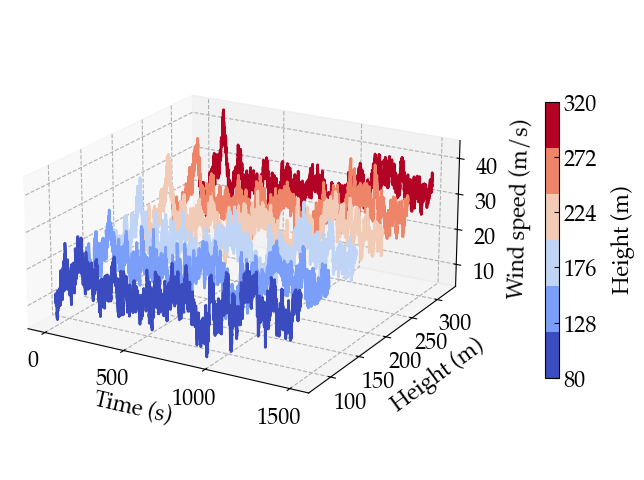

In [28]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'},)
fig.set_constrained_layout(True)
indices = np.arange(0, len(positions)+1, len(positions) // 5)
times = np.arange(0, simulator.params["M"] * simulator.params["dt"], simulator.params["dt"])

cmap = plt.get_cmap("coolwarm", len(indices))
for i, idx in enumerate(indices):

    uz = wind_speeds[indices[i]]
    data = samples[indices[i]] + uz
    z = positions[indices[i], 2]
    z = np.full_like(times, z)
    ax.plot(times, z, data, color=cmap((i)/(len(indices)-1)), 
            label=f"z={z[0]:.1f}m", lw=2, zorder=len(indices)-i)


ax_colorbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, pad=0.1, fraction=0.03)
ax_colorbar.set_label("Height (m)", labelpad=10)
# set value of the colorbar ticks
ax_colorbar.set_ticks([(i)/(len(indices)-1) for i in range(len(indices))])
ax_colorbar.set_ticklabels([f"{positions[idx, 2]:.0f}" for idx in indices])
#


ax.set_box_aspect([2,2,1])
ax.view_init(elev=20, azim=300)
ax.set_xlabel("Time (s)", labelpad=10)
ax.set_ylabel("Height (m)", labelpad=10)
ax.set_zlabel("Wind speed (m/s)", labelpad=5)
# 获取当前3D坐标区的位置 [left, bottom, width, height]
fig.savefig("./img/validate_wind_timehistory_3d.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_wind_timehistory_3d.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_wind_timehistory_3d.pdf", bbox_inches='tight')

In [29]:
from statsmodels.tsa.stattools import adfuller
p_value_list = []
for idx, data in enumerate(samples):
    adf_result = adfuller(data)
    p_value = adf_result[1]
    p_value_list.append(p_value)
p_value_list = np.array(p_value_list)


In [30]:
print("Number of non-stationary series (p-value > 0.05):", np.sum(p_value_list > 0.05))
print("Max p-value:", np.max(p_value_list))

Number of non-stationary series (p-value > 0.05): 0
Max p-value: 0.000551186001142891


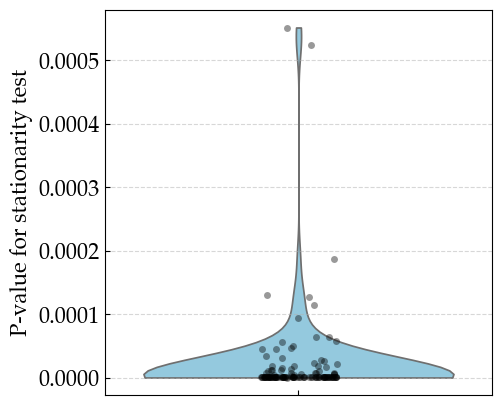

In [31]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
# sns.set_theme(style="whitegrid")
sns.violinplot(y=p_value_list, inner=None, color="skyblue", cut=0, ax=ax)
sns.stripplot(y=p_value_list, color="black", alpha=0.4, jitter=0.1, ax=ax)

ax.set(xlabel="", ylabel="P-value for stationarity test")
fig.savefig("./img/validate_wind_stationarity.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_wind_stationarity.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_wind_stationarity.pdf", bbox_inches='tight')

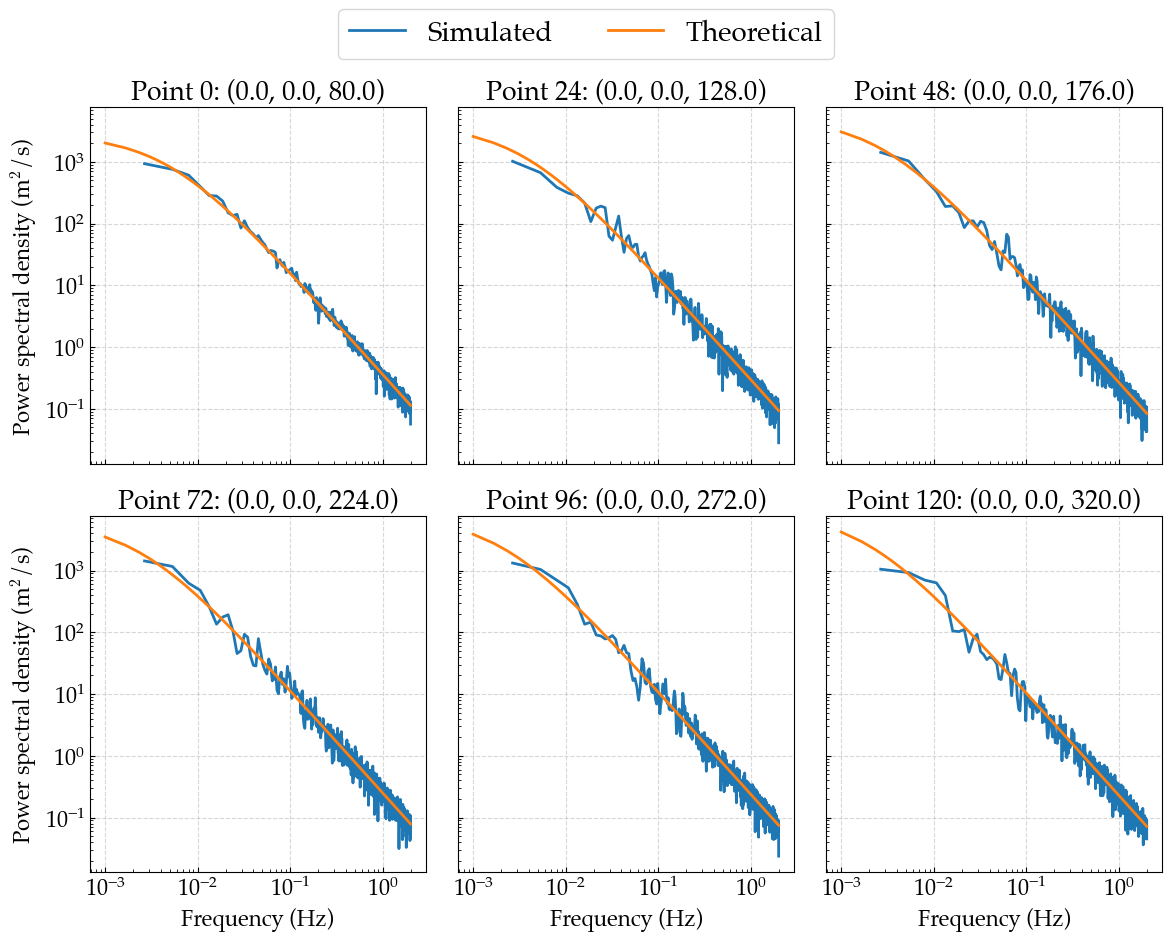

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
axes = axes.flatten()
indices = np.arange(0, len(positions)+1, len(positions) // 5)
for i, idx in enumerate(indices):
    ax = axes[i]
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    ax.loglog(frequencies[1:], 
              psd[1:], label="Simulated", 
              color="C0", lw=2, )
    ax.loglog(
        frequencies_theory[1:],
        S_theory[1:, indices[i]],
        label="Theoretical",
        color="C1",
        lw=2
    )
    x, y, z = positions[indices[i]]
    ax.set_title(f"Point {idx}: ({x:.1f}, {y:.1f}, {z:.1f})")
    if i % 3 == 0:
        ax.set_ylabel("Power spectral density (m$^2$/s)")
    if i >= 3:
        ax.set_xlabel("Frequency (Hz)")

# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=20)
fig.tight_layout()
fig.savefig("./img/validate_psd.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_psd.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_psd.pdf", bbox_inches='tight')


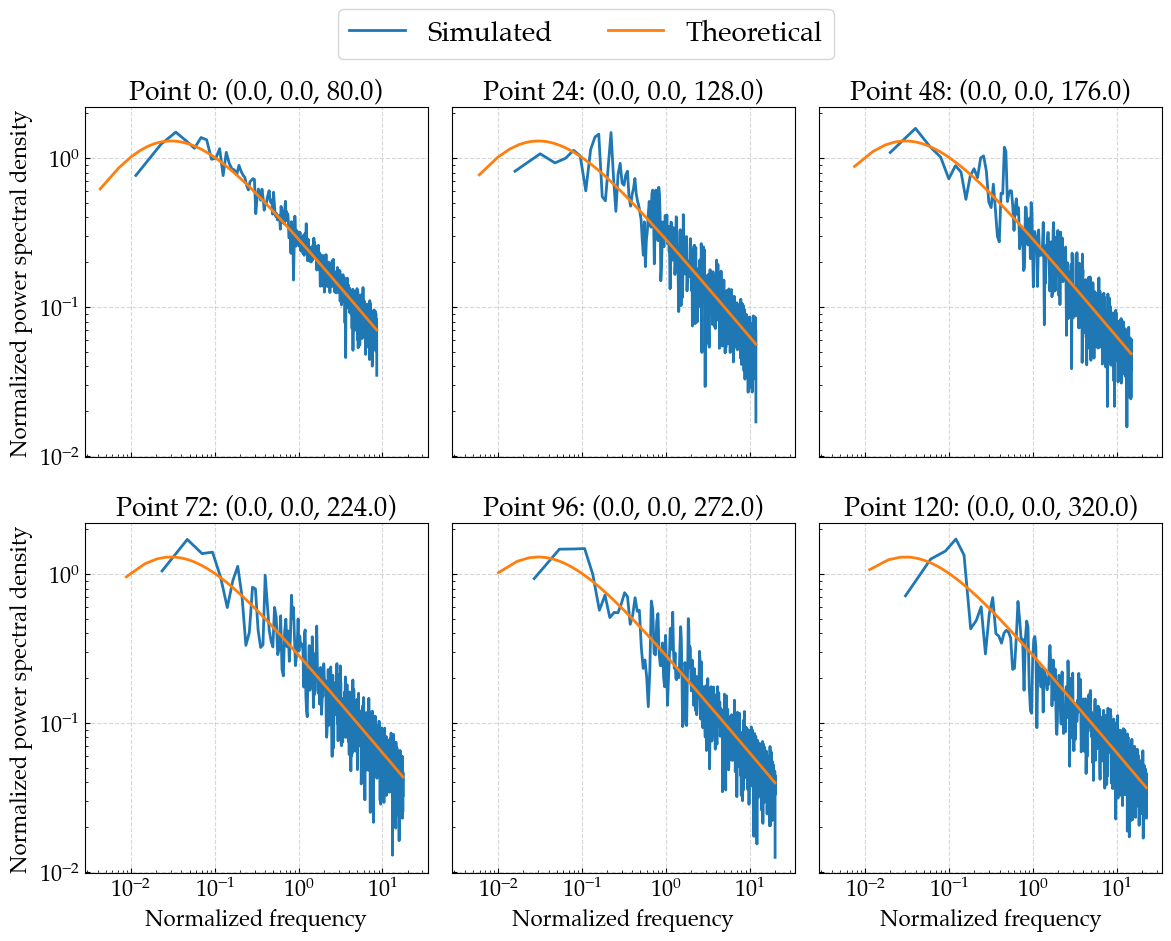

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
axes = axes.flatten()
indices = np.arange(0, len(positions)+1, len(positions) // 5)
for i, idx in enumerate(indices):
    ax = axes[i]
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    u_star = u_stars[indices[i]]
    z = positions[indices[i], 2]
    uz = wind_speeds[indices[i]]
    ax.loglog(frequencies[1:] * z / uz, 
              psd[1:] * frequencies[1:] / u_star**2, label="Simulated", 
              color="C0", lw=2)
    ax.loglog(
        frequencies_theory[1:] * z / uz,
        S_theory[1:, indices[i]] * frequencies_theory[1:] / u_star**2,
        label="Theoretical",
        color="C1",
        lw=2
    )
    x, y, z = positions[indices[i]]
    ax.set_title(f"Point {idx}: ({x:.1f}, {y:.1f}, {z:.1f})")
    if i % 3 == 0:
        # ax.set_ylabel("Power Spectral Density (m$^2$/s)")
        ax.set_ylabel("Normalized power spectral density")
    if i >= 3:
        ax.set_xlabel("Normalized frequency")

# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=20)
fig.tight_layout()
fig.savefig("./img/validate_psd_norm.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_psd_norm.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_psd_norm.pdf", bbox_inches='tight')


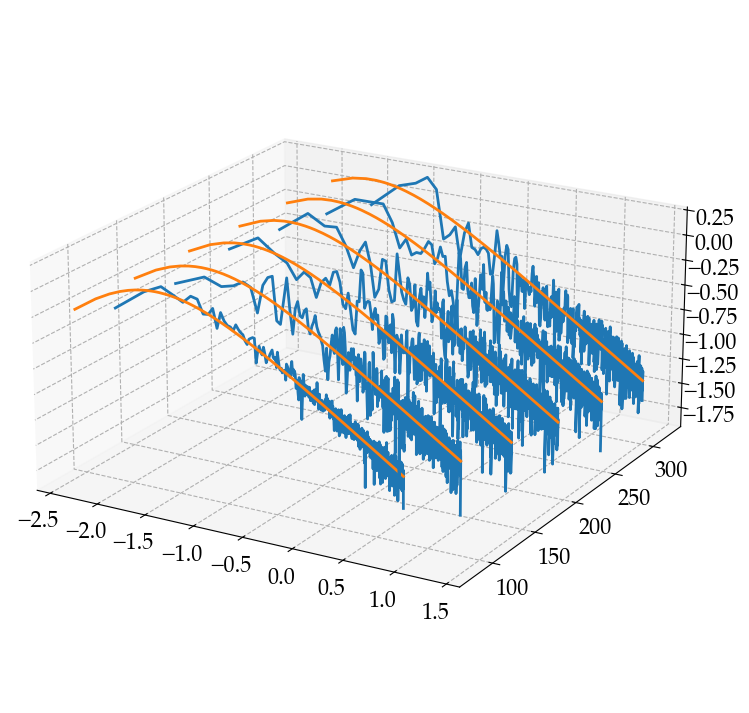

In [52]:
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': '3d'},)
indices = np.arange(0, len(positions)+1, len(positions) // 5)
for i, idx in enumerate(indices):
    data = samples[indices[i]]
    frequencies, psd = signal.welch(
        data,
        fs = 1.0 / simulator.params["dt"],
        nperseg=1500,
        window='hann',
        scaling='density',
    )
    u_star = u_stars[indices[i]]
    z = positions[indices[i], 2]
    uz = wind_speeds[indices[i]]
    # ax.loglog(frequencies[1:] * z / uz, 
    #           psd[1:] * frequencies[1:] / u_star**2, label="Simulated", 
    #           color="C0", lw=2)
    # ax.loglog(
    #     frequencies_theory[1:] * z / uz,
    #     S_theory[1:, indices[i]] * frequencies_theory[1:] / u_star**2,
    #     label="Theoretical",
    #     color="C1",
    #     lw=2
    # )
    normalized_freq = frequencies[1:] * z / uz
    normalized_psd = psd[1:] * frequencies[1:] / u_star**2
    ax.plot(np.log10(normalized_freq), np.full_like(normalized_freq, z), np.log10(normalized_psd),
            label="Simulated", color="C0", lw=2)
    theo_normalized_freq = frequencies_theory[1:] * z / uz
    theo_normalized_psd = S_theory[1:, indices[i]] * frequencies_theory[1:] / u_star**2
    ax.plot(np.log10(theo_normalized_freq), np.full_like(theo_normalized_freq, z), np.log10(theo_normalized_psd),
            label="Theoretical", color="C1", lw=2)

ax.set_box_aspect([2,2,1])
ax.view_init(elev=20, azim=300)


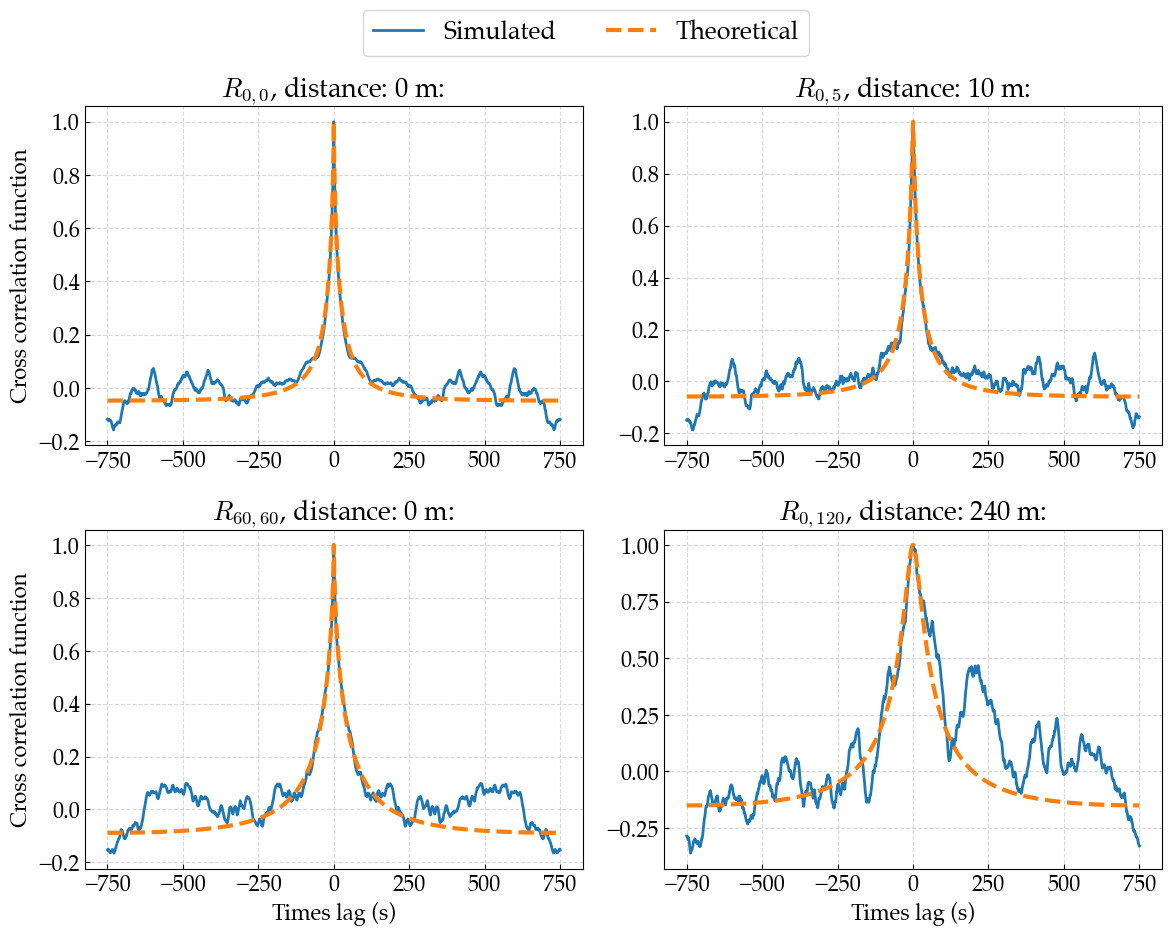

In [34]:
pairs = [(0, 0), (0, 5), (60, 60), (0, 120)]
visualizer = get_visualizer(backend="numpy", key=42, simulator=simulator)
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()
for i, pair in enumerate(pairs):
    ax = axes[i]
    idx1, idx2 = pair
    dist = np.linalg.norm(positions[idx1] - positions[idx2])

    plot_lag_times, plot_corr, theo_plot_times, theo_plot = \
        visualizer.plot_cross_correlation(
            samples,
            positions,
            wind_speeds,
            show=False,
            component="u",
            indices=pair,
            return_data=True
        )
    

    ax.plot(plot_lag_times, plot_corr
            , label="Simulated", color="C0", lw=2)
    ax.plot(theo_plot_times, theo_plot
            , label="Theoretical", color="C1", lw=3, ls="--")
    x1, y1, z1 = positions[idx1]
    x2, y2, z2 = positions[idx2]
    ax.set_title(rf"$R_{{{idx1}, {idx2}}}$" + f", distance: {dist:.0f} m: ")
    if i % 2 == 0:
        ax.set_ylabel("Cross correlation function")
    if i >= 2:
        ax.set_xlabel("Times lag (s)")
    # ax.xaxis.set_major_locator(plt.MultipleLocator(100))
# customize legend
lines, labels = axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=18)
fig.tight_layout()
fig.savefig("./img/validate_correlation.png", dpi=300, bbox_inches='tight')
fig.savefig("./img/validate_correlation.pdf", bbox_inches='tight')
fig.savefig("../wind_simulation_paper/validate_correlation.pdf", bbox_inches='tight')

In [35]:
def compute_coherence(x, y, fs, nperseg=1000):
    """Compute the coherence between two signals."""
    frequencies, Cxy = signal.coherence(
        x, y,
        fs=fs,
        nperseg=nperseg,
        window='hamming',
    )
    return frequencies, Cxy


pair = (0, 1, )
x_i, x_j = positions[pair, 0:1], positions[pair, 0:1].T  # (n, 1), (1, n)
y_i, y_j = positions[pair, 1:2], positions[pair, 1:2].T  # (n, 1), (1, n)
z_i, z_j = positions[pair, 2:3], positions[pair, 2:3].T  # (n, 1), (1, n)
U_i, U_j = wind_speeds[pair, None], wind_speeds[None, pair]  # (n, 1), (1, n)
frequencies = simulator.calculate_simulation_frequency(
    simulator.params["N"], simulator.params["dw"]
)


theoretical_coherence = np.array([
    simulator.calculate_coherence(
    x_i, x_j, y_i, y_j, z_i, z_j, freq_l, U_i, U_j,
    simulator.params["C_x"], simulator.params["C_y"], simulator.params["C_z"])
    for freq_l in frequencies
]) # (len(frequencies), n, n)





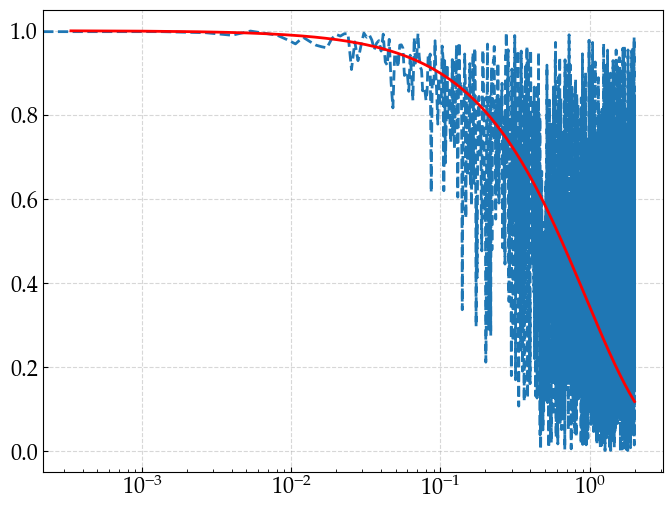

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
for idx, i in enumerate(pair):
    if idx == 0:
        continue
    measured_frequencies, measured_coherence = compute_coherence(
        samples[pair[0]], samples[pair[idx]],
        fs=1.0 / simulator.params["dt"],
        nperseg=simulator.params["N"],
    )
    ax.plot(measured_frequencies, measured_coherence, label=f"Simulated {idx}", lw=2, ls='--',)
    ax.plot(frequencies, theoretical_coherence[:, idx, 0], label=f"Theoretical {idx}", 
            lw=2, color=f"red")
ax.set_xscale('log')

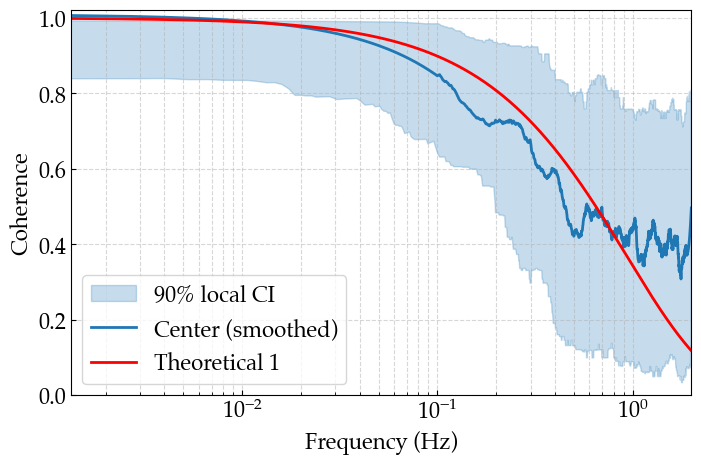

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# 参数：可调整
pct = (10, 90)                    # 下/上百分位 -> 90% 区间
window_frac = 0.10               # 在频域上邻域大小，相对长度 (可调)
savgol_poly = 3                  # Savitzky-Golay 多项式阶数
show_raw = False                 # 是否同时画原始噪声曲线

# measured_frequencies, measured_coherence 应在上下文已定义
f = np.asarray(measured_frequencies)
coh = np.asarray(measured_coherence)
n = len(coh)
if n == 0:
    raise ValueError("measured_coherence is empty")

# 计算滑动窗口长度（以点数），保证为奇数且至少 5
win_pts = int(max(5, np.round(window_frac * n)))
if win_pts % 2 == 0:
    win_pts += 1
if win_pts > n:
    win_pts = n if n % 2 == 1 else n - 1

# 中心线：Savitzky-Golay 平滑（若太短则退化为原始）
if n >= 7 and win_pts >= 5:
    try:
        center = savgol_filter(coh, window_length=win_pts, polyorder=min(savgol_poly, 2))
    except Exception:
        center = coh.copy()
else:
    center = coh.copy()

# 置信区间：在频率索引邻域内计算局部百分位（仅用序列本身）
half = win_pts // 2
lower = np.empty(n)
upper = np.empty(n)
for i in range(n):
    lo = max(0, i - half)
    hi = min(n, i + half + 1)
    window_vals = coh[lo:hi]
    lower[i] = np.percentile(window_vals, pct[0])
    upper[i] = np.percentile(window_vals, pct[1])

# 理论曲线（若存在 frequencies(omega) 与 theoretical_coherence）
theo_curve = None
try:
    # frequencies 是角频率数组（rad/s），转换为 Hz 并插值
    freqs_hz = frequencies / (2.0 * np.pi)
    theo_curve = np.interp(f, freqs_hz, theoretical_coherence[:, pair[1], pair[0]])
except Exception:
    theo_curve = None

# 绘图
fig, ax = plt.subplots(figsize=(8, 5))
if show_raw:
    ax.plot(f, coh, color='C0', alpha=0.25, lw=1, label='Measured (raw)')
ax.fill_between(f, lower, upper, color='C0', alpha=0.25, label=f'{(100-pct[0]):.0f}% local CI')
ax.plot(f, center, color='C0', lw=2, label='Center (smoothed)')
ax.plot(frequencies, theoretical_coherence[:, idx, 0], label=f"Theoretical {idx}", 
            lw=2, color=f"red")
ax.set_xscale('log')
ax.set_xlim(f[1] if len(f)>1 else f[0], f[-1])
ax.set_ylim(0, 1.02)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coherence')
ax.grid(True, which='both', ls='--', alpha=0.5)
ax.legend()
plt.show()